## todo:
- rename big_frame_Bitcoin this to other general name

Installed packages: keras, tensorflow

In [48]:
%store -r big_frame

In [49]:
big_frame

,Date,Price,Open,High,Low,Volume,Change,coin_name_abbrv,coin_name
0,2021-04-25,498.37000,497.46000,504.23000,486.09000,2.04,0.18%,Bin,Binance
1,2021-04-24,497.50000,526.52000,527.18000,483.39000,3.16,-5.52%,Bin,Binance
2,2021-04-23,526.56000,505.12000,529.95000,450.94000,7.19,4.10%,Bin,Binance
3,2021-04-22,505.84000,543.30000,582.15000,482.81000,6.69,-6.90%,Bin,Binance
4,2021-04-21,543.34000,587.45000,612.86000,537.64000,5.96,-7.52%,Bin,Binance
...,...,...,...,...,...,...,...,...,...
16764,2015-01-26,0.01469,0.01700,0.01750,0.01469,0.00,-13.59%,XRP,XRP
16765,2015-01-25,0.01700,0.01739,0.01739,0.01560,0.00,-2.24%,XRP,XRP
16766,2015-01-24,0.01739,0.01600,0.01739,0.01500,0.00,8.69%,XRP,XRP
16767,2015-01-23,0.01600,0.01602,0.01700,0.01600,0.00,-0.12%,XRP,XRP


In [50]:
'''big_frame_shuffled = big_frame.sample(frac=1)
big_frame_shuffled = big_frame_shuffled.set_index('Date')
big_frame_shuffled = big_frame_shuffled.sort_index(axis=0)
big_frame_shuffled'''



"big_frame_shuffled = big_frame.sample(frac=1)\nbig_frame_shuffled = big_frame_shuffled.set_index('Date')\nbig_frame_shuffled = big_frame_shuffled.sort_index(axis=0)\nbig_frame_shuffled"

In [51]:
def getData(coin):
    big_frame_Bitcoin = big_frame[big_frame['coin_name']==coin]
    big_frame_Bitcoin = big_frame_Bitcoin.set_index('Date')
    big_frame_Bitcoin = big_frame_Bitcoin.drop(['Volume','Change', 'coin_name_abbrv', 'coin_name'], axis=1)
    return big_frame_Bitcoin

display(getData('XRP'))

,Price,Open,High,Low
Date,,,,
2021-04-25,1.04990,1.05015,1.07318,1.03182
2021-04-24,1.05015,1.17025,1.17095,1.02325
2021-04-23,1.17023,1.15859,1.19593,0.89374
2021-04-22,1.15886,1.29067,1.41758,1.10427
2021-04-21,1.29046,1.38614,1.46239,1.28289
...,...,...,...,...
2015-01-26,0.01469,0.01700,0.01750,0.01469
2015-01-25,0.01700,0.01739,0.01739,0.01560
2015-01-24,0.01739,0.01600,0.01739,0.01500


## Importing all required libraries

In [52]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

# Splitting dataset into training and testing data.
## 80% - Training
## 20% - Testing

In [53]:
def train_test_split(df, test_size=0.2):
    split_row = int(test_size * len(df))
    test_data = df.iloc[:split_row]
    train_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(getData('Dogecoin'), test_size=0.2)

# Plotting Cryptocurrency price in USD

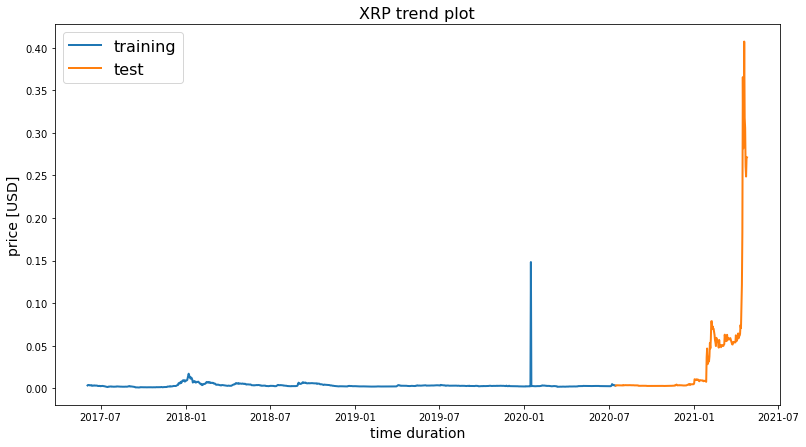

In [54]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel('time duration', fontsize=14)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

target_col = 'Price'
line_plot(train[target_col], test[target_col], 'training', 'test', title='XRP trend plot')

# Normalizing numeric columns to change it to a common scale

In [55]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

# def normalise_min_max(df):
#     return (df - df.min()) / (data.max() - df.min())

## Function to extract window each of size 5

In [56]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

## Function to prepare data in the format so as to feed it later into the Neural Network

In [57]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

# LSTM:
Data has to be processed through various gates like forget gate, input gate etc.
Various activation functions like tanh, relu and is passed through LSTM cells.

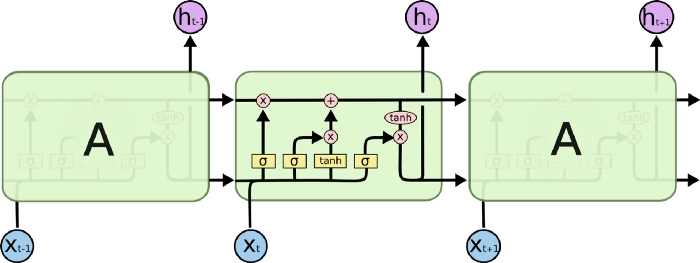

In [58]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [63]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 5
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [64]:
big_frame_Bitcoin = getData('Dogecoin')
train, test, X_train, X_test, y_train, y_test = prepare_data(
    big_frame_Bitcoin, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

# display(train)
# display(test)
# display(X_train)
# display(X_test)
# display(y_train)
# display(y_test)

In [65]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
36/36 [==============================] - 5s 8ms/step - loss: 1.7629
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 3.6615
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 3.2570
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 2.0619
Epoch 5/20
36/36 [==============================] - 0s 9ms/step - loss: 2.1267
Epoch 6/20
36/36 [==============================] - 0s 9ms/step - loss: 0.7840
Epoch 7/20
36/36 [==============================] - 0s 8ms/step - loss: 4.6476
Epoch 8/20
36/36 [==============================] - 0s 8ms/step - loss: 0.4991
Epoch 9/20
36/36 [==============================] - 0s 9ms/step - loss: 4.1133
Epoch 10/20
36/36 [==============================] - 0s 8ms/step - loss: 0.6148
Epoch 11/20
36/36 [==============================] - 0s 9ms/step - loss: 4.9072
Epoch 12/20
36/36 [==============================] - 0s 9ms/step - loss: 0.4463
Epoch 13/20
36/36 [==============================

mean_absolute_error =  0.023380902897746626


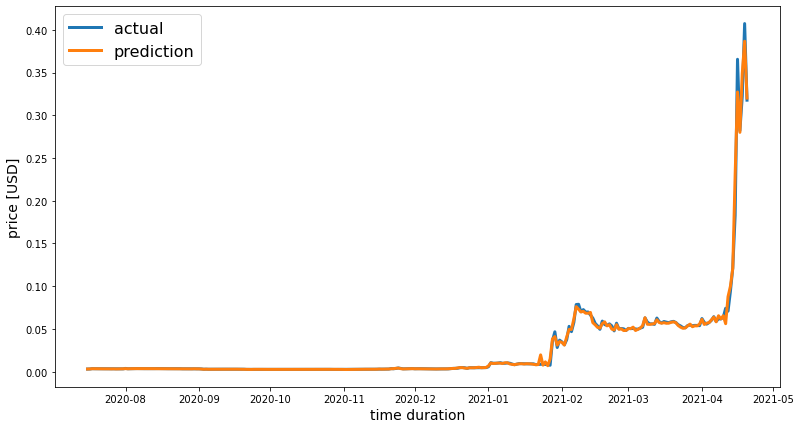

In [66]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print('mean_absolute_error = ', mean_absolute_error(preds, y_test))
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
# line_plot(preds, preds, 'actual', 'prediction', lw=3)